In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

In [3]:
df = load_proteome_as_df('Human')
print('multiple seqs', len(df['Sequence'])-len(df['Sequence'].unique()))
df.drop_duplicates(subset=['Sequence'], inplace=True)

multiple seqs 66


In [4]:
counter = count_kmers_iterable(df['Sequence'], 10)

In [5]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series

In [6]:
count_series = counter_to_series(counter)

In [7]:
np.sum(count_series[count_series>1])/np.sum(count_series)

0.12031363661674797

In [9]:
count_series.sort_values().tail(10)

HTGEKPYKCE    334
YKCEECGKAF    356
QRIHTGEKPY    360
KPYKCEECGK    369
AAAAAAAAAA    395
SSSSSSSSSS    398
EEEEEEEEEE    412
HQRIHTGEKP    428
IHTGEKPYKC    553
QQQQQQQQQQ    700
Name: count, dtype: int64

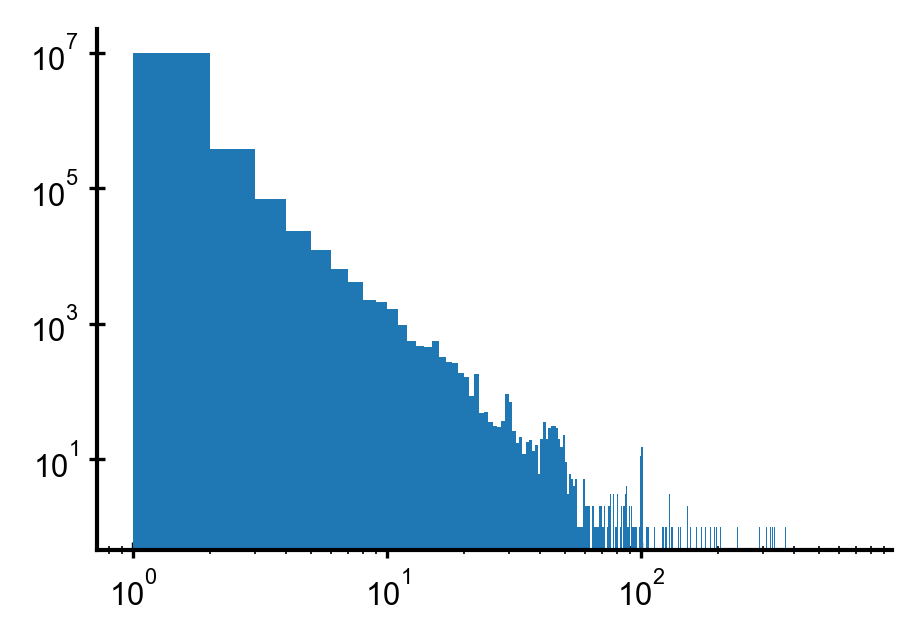

In [12]:
plt.hist(count_series, log=True, bins=np.arange(0, count_series.max()+1, 1));
plt.xscale('log')

In [13]:
counter_filtered = count_kmers_iterable(count_series.index.str[:9], 9)

In [14]:
count_series_filtered = counter_to_series(counter_filtered)

In [15]:
count_series_unfiltered = counter_to_series(count_kmers_iterable(df['Sequence'], 9))

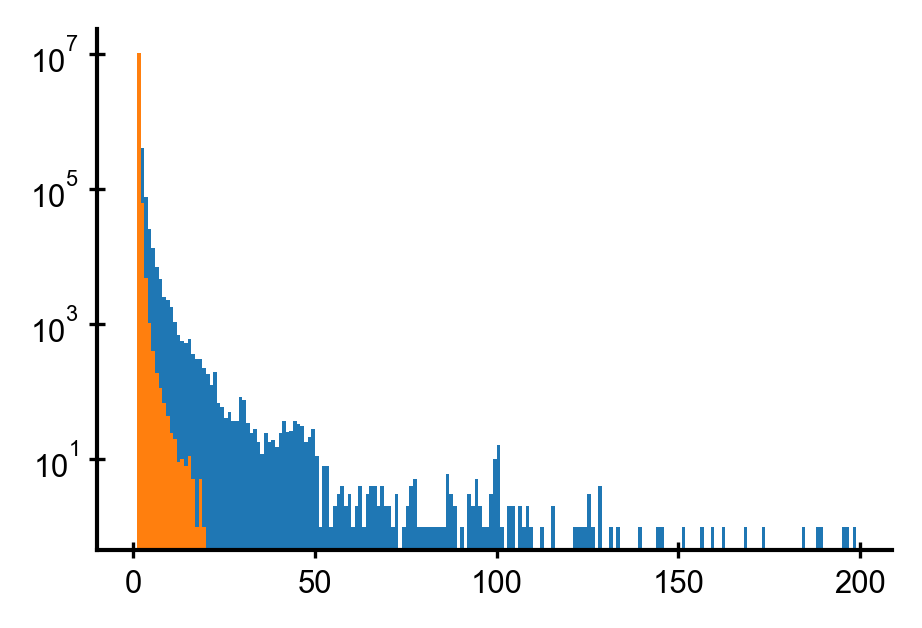

In [16]:
plt.hist(count_series_unfiltered, log=True, bins=np.arange(0, 200, 1))
plt.hist(count_series_filtered, log=True, bins=np.arange(0, 200, 1));

In [19]:
'{:.3e}, {:.3e}'.format(len(count_series_filtered), len(count_series_unfiltered))

'1.038e+07, 1.040e+07'

In [21]:
count_series_unfiltered.sort_values().tail(10)

RTHTGEKPY    434
HQRIHTGEK    446
SSSSSSSSS    492
AAAAAAAAA    552
IHTGEKPYK    560
EEEEEEEEE    560
HTGEKPYEC    690
QQQQQQQQQ    787
RIHTGEKPY    807
HTGEKPYKC    873
Name: count, dtype: int64

In [22]:
count_series_filtered.sort_values().tail(10)

KCKECGKAF    16
ECKECGKAF    16
RTHTGEKPY    16
SSSSSSSSS    17
AAAAAAAAA    18
CKECGKAFS    18
RIHTGEKPY    18
HTGEKPYKC    18
EEEEEEEEE    18
HTGEKPYEC    19
Name: count, dtype: int64